In this notebook, we aim at doing LD experiments with some network. Here, we focus on voting power. More specifically the Benzaff index, which corresponds to the probability for a given voter in a network to be decisive in the output of the rule. A voter is decisive if it can changes the result only by changing its vote.

In this work, we consider differents models, and for each model we will look at differents parameters and there impact on voting power.

1. G(n,p) graph with n voters and each edge having probability p to exists (undirected)
    * percentage of edges p
2. Preferrential attachment model (directed or undirected ?)
    * Time of introduction in the network (+ try to decorrelate it from the degree)
    * Attachment parameter p
3. Spatial model (undirected)
    * Distance to center
    * Approval radius r
4. Small world
    * I need to look how it works and what are the parameters

We will also look in every model at the impact of the degree of the voter and its centrality on its voting power.

We will also consider real world networks :

1. Facebook (undirected networks)
2. Twitter (directed networks)
3. Others

In this work, we assume a Weighted Voting Game (WVG) were all voters have weight 1, except if stated otherwise. We might also consider games with different voting weight. In this WVG, the quota is $q = 0.5$.

In [5]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

In [6]:
import networkx as nx

G = nx.Graph()

elist = [(1, 2), (2, 3), (1, 4), (4, 2)]

G.add_edges_from(elist)

# Voting power with underlying network

In [7]:
def create_bill_LD(n, network):
    '''
    This function create a delegation partition for LD,  
    It select with v_d if voters delegate (v_d_d[i] = 0) or vote directly
    Then we will look at v_1 if they vote directly, v_2 if they delegate and we take care of avoiding self delegations.
    We assume that all voters are of weight 1  and the WVG is with q = 0.5.
    '''
    v_d = np.zeros(n, dtype=int)
    v_1 = np.random.randint(2, size=(n), dtype=int)
    v_2 = np.zeros(n, dtype=int)
    for i in range(n):
        neighbors = list(nx.neighbors(network, i))
        if 2/(len(neighbors)+2) >= np.random.rand():
            v_d[i] = 1
            continue
        v_2[i] = neighbors[np.random.randint(len(neighbors))]            
    return v_d, v_1, v_2

In [8]:
def compute_result(v_d, v_1, v_2, weights):
    '''
    This function takes as input a delegation instance, and weights of voters, and compute the results of the election in
    this delegation instance
    '''
    n = len(v_d)
    
    # V is the vector of final vote (+1, -1 or 0 if the voter is abstaining)
    v = np.zeros(n)
    
    # We push in q all the delegating voters
    q = []
        
    for i in range(n):
        if v_d[i]:
            v[i] = 2*v_1[i]-1
        else:
            q.append(i)
            
            
    # We propagate the vote of direct voters to the voters delegating to them until we've seen all the voters
    # The idea is similar to a DFS, but in a tree.
    abst = []
    while q != []:
        x = q.pop()
        if x in abst or v[x] != 0:
            continue
        seen = []
        while x not in seen and x not in abst and v[x] == 0:
            seen.append(x)
            x = v_2[x]
        
        if x in seen or x in abst:
            for y in seen:
                if y not in abst:
                    abst.append(y)
        else:
            r = v[x]
            for y in seen:
                v[y] = r
                
    # We compute the results
    r = v.dot(weights)
    
    return r >=0, v

def test_critical_LD( network, weights):
    '''
    This function takes as input the number of voters, the probability to delegate and the weights
    in the LD setting, create a delegation partition, and count the number of voters in each group that are critical.
    We assume that we are in a WVG with q = 0.5. We also assume that weights are natural number between 1 and 9.
    '''
    n = len(network)
    v_d, v_1, v_2 = create_bill_LD(n, network)
    res, v = compute_result(v_d, v_1, v_2, weights)
    
    power = np.zeros(n)
    
    # We look for every voter that agree with the result if the result would change if this voter changes his vote.
    for i in range(n):
        res2 = res
        if v[i] != -1 and res == 1:
            v_d_copy = v_d.copy()
            v_d_copy[i] = 1
            v_1_copy = v_1.copy()
            v_1_copy[i] = 0
            res2, _ = compute_result(v_d_copy, v_1_copy, v_2, weights)
            
        elif v[i] != 1 and res == 0:
            v_d_copy = v_d.copy()
            v_d_copy[i] = 1
            v_1_copy = v_1.copy()
            v_1_copy[i] = 1
            res2, _ = compute_result(v_d_copy, v_1_copy, v_2, weights)
        if res != res2:
            power[i] = 1
    
    
    return power
            
    

In [9]:
def network_powers(network, weights, n_trys= 10000):
    """
    This function will estimate the criticality of every node in the graph.
    """
    n = len(network)
    powers = np.zeros(n)
    for _ in tqdm(range(n_trys)):
        powers += test_critical_LD(network, weights)
        
    return powers/n_trys
    

# Model generators

## Complete graph

In [10]:
def network_complete(n_voters):
    """
    This function generate a complete graph
    """
    return nx.complete_graph(n_voters, nx.DiGraph())

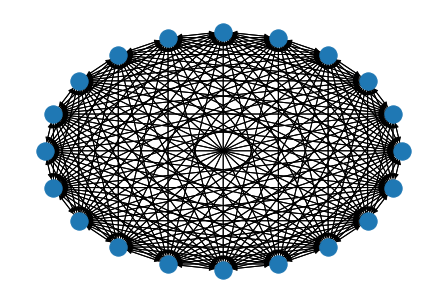

In [11]:
G = network_complete(20)
nx.draw_circular(G)

## Random graph

In [15]:
def network_random(n_voters, proba_edges):
    m_edges = int(proba_edges*n_voters*(n_voters-1)/2)
    
    return nx.gnm_random_graph(n_voters, m_edges)

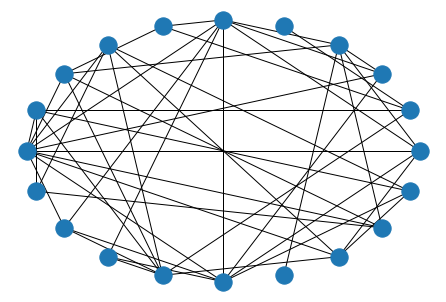

In [17]:
G = network_random(20,0.25)
nx.draw_circular(G)

## k-level graph

In [27]:
def network_k_partite(n_voters):
    """
    This function generate a graph with k level and each level is totally connected to the next one (neural network style).
    """
    
    e_list = []
    s = 0
    for k in range(len(n_voters)-1):
        for i in range(n_voters[k]):
            for j in range(n_voters[k+1]):
                e_list.append((s+i,s+n_voters[k]+j))
        s += n_voters[k]
    network = nx.DiGraph()
    network.add_nodes_from(range(np.sum(n_voters)))
    network.add_edges_from(e_list)
    return network


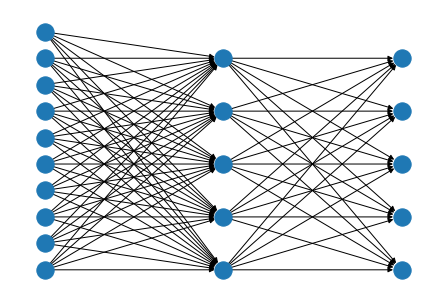

In [29]:
G = network_k_partite([10,5,5])
nx.draw(G,[[0,0.1*i] for i in range(10)] + [(1,0.2*i) for i in range(5)] + [(2,0.2*i) for i in range(5)])

## Preferential attachment

In [55]:
def network_preferential_attachment(n_voters, proba_edges):
    """
    This function generate a graph based on the Barabasi Albert preferential attachment model
    NOTE : it does not generate a DiGraph
    """
    m_edges = int(n_voters*proba_edges)
    
    return nx.barabasi_albert_graph(n_voters, m_edges)

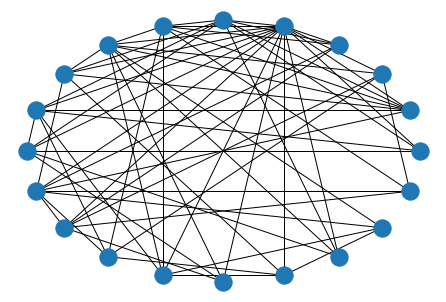

In [57]:
G = network_preferential_attachment(20,0.2)
nx.draw_circular(G)

## Small world

In [58]:
def network_small_world(n_voters, k_neighbours, p_rewiring):
    """
    This function generate a graph based on the watts strogatz small world model
    """
    return nx.watts_strogatz_graph(n_voters, k_neighbours, p_rewiring)

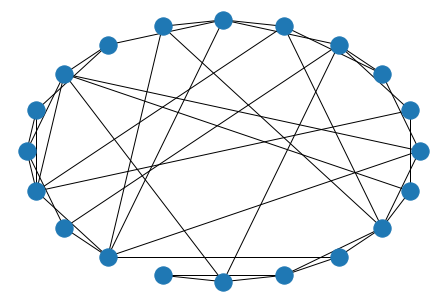

In [62]:
G = network_small_world(20,4, 0.25)
nx.draw_circular(G)

## Spatial model

In [74]:
def matrix_dist(pos):
    n = len(pos)
    M = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            M[i, j] = np.sqrt((pos[i][0] - pos[j][0]) ** 2 + (pos[i][1] - pos[j][1]) ** 2)
            M[j, i] = np.sqrt((pos[i][0] - pos[j][0]) ** 2 + (pos[i][1] - pos[j][1]) ** 2)

    return M



def network_spatial(n_voters, k_neighbors, distrib_x="uniform", distrib_y="uniform"):
    """
    Create a synthetic delegation network with the spatial method. In this method, first we put every voter
    on a 2D plane, then each delegating voter delegates to the voters the closest to him.

    Parameters
    ----------
    n_voters
        Number of voters in the election

    p_casting
        Proportion of casting voters in the election

    n_delegatees
        Number of delegatees per voters

    distrib_x
        Distribution for the x coordinate (either "gauss" or "uniform")

    distrib_y
        Distribution for the y coordinate (either "gauss" or "uniform")

    Returns
    -------
    election: Election
        The Election with voters
    pos: list
        The list of position of voters on the spatial plane

    """

    distribs = [distrib_x, distrib_y]
    pos = np.zeros((n_voters, 2))
    for j in range(2):
        if distribs[j] == "uniform":
            pos[:,j] = np.random.rand(n_voters)*2-1
        elif distribs[j] == "gauss":
            pos[:,j] = np.random.normal(size=n_voters)
 
    M = matrix_dist(pos)
    edges_list = []
    for i in range(n_voters):
        list_neighbors = np.argsort(M[i])[1:k_neighbors+1]
        for x in list_neighbors:
            edges_list.append((i,x))

    network = nx.DiGraph()
    network.add_nodes_from([(x, {"x":pos[x,0], "y":pos[x,1]}) for x in range(n_voters)])
    network.add_edges_from(edges_list)
    return network


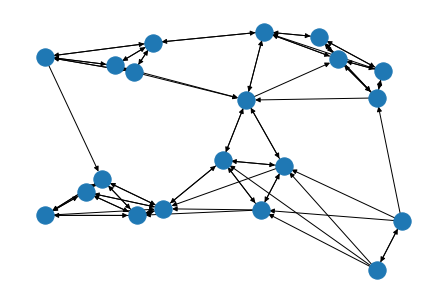

In [77]:
G = network_spatial(20,4)
nx.draw(G, [[G.nodes[i]["x"], G.nodes[i]["y"]] for i in range(20)])

# Experiments

## Random graph, evolution with proba

Experiments possible :

* For a given graph G(n,p) with given parameters, how the power vary with the degree ? the centrality ?
* How the power vary with the probability of edges p ?

In [84]:
n_voters = 100
proba_list = np.linspace(0,1,11)
powers = np.zeros((11, n_voters))
for i, p in enumerate(proba_list):
    G = network_random(n_voters,p)
    powers[i] = network_powers(G, np.ones(n_voters))

  4%|▍         | 434/10000 [00:02<00:49, 194.29it/s]


KeyboardInterrupt: 

In [ ]:
plt.plot(proba_list, powers.mean(1), 'o-', "k")

## Spatial

Experiments : 

* For a given graph
* Evolution with number of neighbors ?
* I expect to have more inequalities in the Gauss model than Uniform model

In [93]:
n_voters = 100
G = network_spatial(n_voters,8)
powers = network_powers(G, np.ones(n_voters))

100%|██████████| 10000/10000 [08:36<00:00, 19.35it/s]


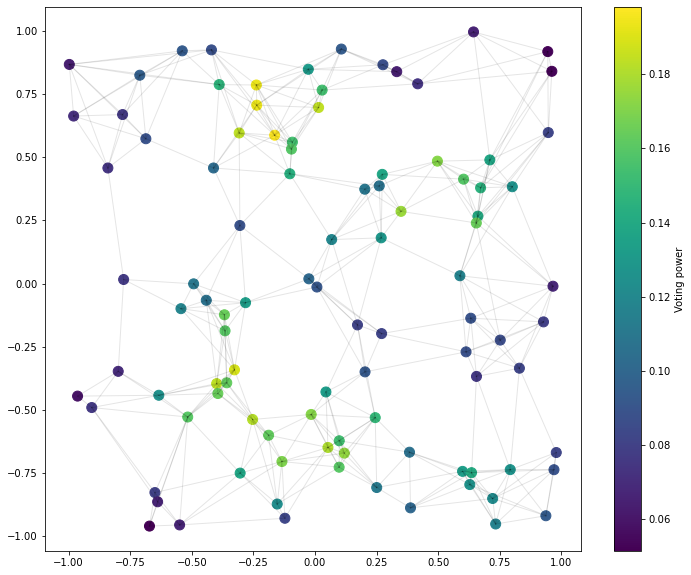

In [94]:

#nx.draw(G, [[G.nodes[i]["x"], G.nodes[i]["y"]] for i in range(100)])
plt.figure(figsize=(12,10))
for i in range(n_voters):
    neighbors = list(nx.neighbors(G,i))
    for j in neighbors:
        if j > i:
            plt.plot([G.nodes[i]["x"], G.nodes[j]["x"]], [G.nodes[i]["y"], G.nodes[j]["y"]], 'k', linewidth=1, alpha=0.1)
sc = plt.scatter([G.nodes[i]["x"] for i in range(n_voters)],[G.nodes[i]["y"] for i in range(n_voters)], c =powers,  s=100)
            
plt.colorbar(sc, label="Voting power")
plt.show()

In [96]:
pos = [[G.nodes[i]["x"],G.nodes[i]["y"]] for i in range(n_voters)]

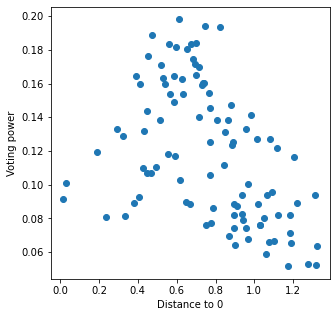

In [97]:
plt.figure(figsize=(5,5))

norm_val = np.zeros(n_voters)
for i in range(n_voters):
    norm_val[i]= (np.linalg.norm(pos[i]))
    
plt.plot(norm_val, powers, 'o')
plt.xlabel("Distance to 0")
plt.ylabel("Voting power")
plt.show()

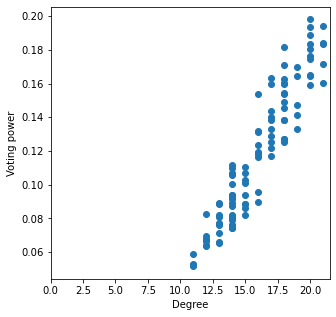

In [98]:
plt.figure(figsize=(5,5))

degrees = np.zeros(n_voters)
for i in range(n_voters):
    degrees[i]= nx.degree(G,i)
    
plt.plot(degrees, powers, 'o')
plt.xlim(0)
plt.xlabel("Degree")
plt.ylabel("Voting power")
plt.show()

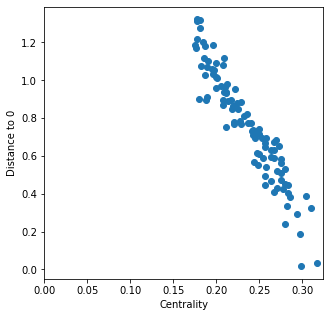

In [100]:
centrality = nx.closeness_centrality(G)
plt.figure(figsize=(5,5))

centrality_n = np.zeros(n_voters)
for i in range(n_voters):
    centrality_n[i]= centrality[i]
    
plt.plot(centrality_n, norm_val, 'o')
plt.xlim(0)
plt.xlabel("Centrality")
plt.ylabel("Distance to 0")
plt.show()

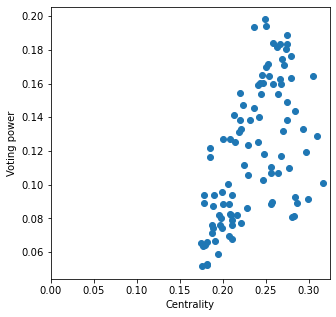

In [101]:
plt.figure(figsize=(5,5))

centrality_n = np.zeros(n_voters)
for i in range(n_voters):
    centrality_n[i]= centrality[i]
    
plt.plot(centrality_n, powers, 'o')
plt.xlim(0)
plt.xlabel("Centrality")
plt.ylabel("Voting power")
plt.show()

## Preferential attachment

Experiments : 
* Evolution with parameter (proba of edges)

## Small World

Experiments : 
* Evolution with number of neighbors and proba of rewiring

## k-level

Experiments :
* bipartite
* 5-level
* pyramid

In [104]:
n_voters=100
powers = np.zeros((11, n_voters))

for i, p in enumerate([2,3,4,5]):
    tab_voters = [n_voters//p]*p
    if np.sum(tab_voters) != n_voters:
        tab_voters[0] += n_voters - np.sum(tab_voters)
    G = network_k_partite(tab_voters)
    powers[i] = network_powers(G, np.ones(n_voters))

100%|██████████| 10000/10000 [02:19<00:00, 71.74it/s]


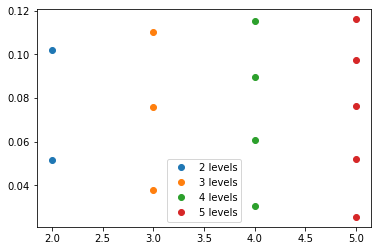

In [126]:

for i, p in enumerate([2,3,4,5]):
    tab_voters = [n_voters//p]*p
    if np.sum(tab_voters) != n_voters:
        tab_voters[0] += n_voters - np.sum(tab_voters)
    
    tab_voters = [0] + tab_voters
    avg_powers = np.zeros(p)
    for j, x in enumerate(tab_voters[:-1]):
        avg_powers[j] = powers[i,np.cumsum(tab_voters)[j]:np.cumsum(tab_voters)[j+1]].mean()
        
    plt.plot([p]*p, avg_powers,'o', label="%i levels"%p)
    
plt.legend()
plt.show()

In [127]:
n_voters=100
powers = np.zeros((11, np.sum([81,27,9,3,1])))

for i, p in enumerate(range(1,6)):
    tab_voters = [81,27,9,3,1][5-p:]
    n_voters = np.sum(tab_voters)
    G = network_k_partite(tab_voters)
    powers[i,:n_voters] = network_powers(G, np.ones(n_voters))
    


100%|██████████| 10000/10000 [03:28<00:00, 47.86it/s]


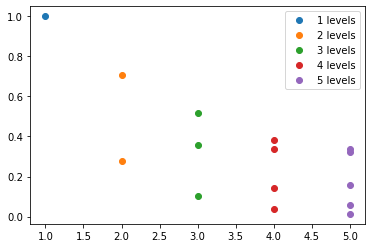

In [130]:

for i, p in enumerate(range(1,6)):
    tab_voters =[0] + [81,27,9,3,1][5-p:]
    avg_powers = np.zeros(p)
    for j, x in enumerate(tab_voters[:-1]):
        avg_powers[j] = powers[i,np.cumsum(tab_voters)[j]:np.cumsum(tab_voters)[j+1]].mean()
        
    plt.plot([p]*p, avg_powers,'o', label="%i levels"%p)
    
plt.legend()
plt.show()

# OLD (below)

## Spatial model

In [49]:
def matrix_dist(pos):
    n = len(pos)
    M = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            M[i, j] = np.sqrt((pos[i][0] - pos[j][0]) ** 2 + (pos[i][1] - pos[j][1]) ** 2)
            M[j, i] = np.sqrt((pos[i][0] - pos[j][0]) ** 2 + (pos[i][1] - pos[j][1]) ** 2)

    return M



def network_spatial(n_voters=1000, radius=0.2, distrib_x="gauss", distrib_y="gauss"):
    """
    Create a synthetic delegation network with the spatial method. In this method, first we put every voter
    on a 2D plane, then each delegating voter delegates to the voters the closest to him.

    Parameters
    ----------
    n_voters
        Number of voters in the election

    p_casting
        Proportion of casting voters in the election

    n_delegatees
        Number of delegatees per voters

    distrib_x
        Distribution for the x coordinate (either "gauss" or "uniform")

    distrib_y
        Distribution for the y coordinate (either "gauss" or "uniform")

    Returns
    -------
    election: Election
        The Election with voters
    pos: list
        The list of position of voters on the spatial plane

    """

    distribs = [distrib_x, distrib_y]
    pos = np.zeros((n_voters, 2))
    for j in range(2):
        if distribs[j] == "uniform":
            pos[:,j] = np.random.rand(n_voters)*2-1
        elif distribs[j] == "gauss":
            pos[:,j] = np.random.normal(size=n_voters)
 
    M = matrix_dist(pos)
    edges_list = []
    for i in range(n_voters):
        for j in range(i+1, n_voters):
            if M[i,j] <= radius:
                edges_list.append((i,j))

    network = nx.Graph()
    network.add_nodes_from(range(n_voters))
    network.add_edges_from(edges_list)
    return pos, network


In [135]:
n_voters = 100
pos, G = network_spatial(n_voters, radius = 0.5)
powers = network_powers(G, np.ones(n_voters), 0.5)

100%|██████████| 10000/10000 [02:43<00:00, 61.11it/s]


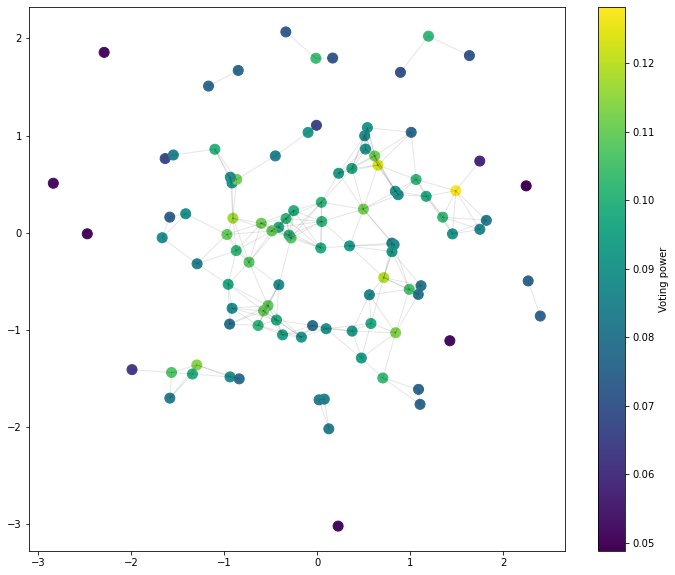

In [136]:
plt.figure(figsize=(12,10))
for i in range(n_voters):
    neighbors = list(nx.neighbors(G,i))
    for j in neighbors:
        if j > i:
            plt.plot([pos[i,0], pos[j,0]], [pos[i,1],pos[j,1]], 'k', linewidth=1, alpha=0.1)
sc = plt.scatter(pos[:,0], pos[:,1], c =powers,  s=100)
            
plt.colorbar(sc, label="Voting power")
plt.show()

In [137]:
# Prouver qu'on est dans l'erreur
# - eps et + eps (add) ou (mult)
# => Approximation additive avec sample
# => Multiplicative ?
# Preuve de complexité WVG dans le cas general (il existe un graphe) NP-complet

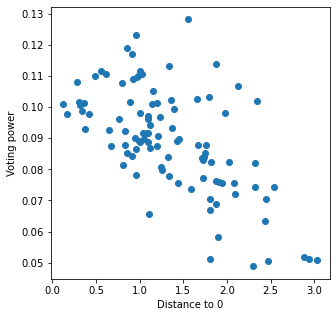

In [138]:
plt.figure(figsize=(5,5))

norm_val = np.zeros(n_voters)
for i in range(n_voters):
    norm_val[i]= (np.linalg.norm(pos[i]))
    
plt.plot(norm_val, powers, 'o')
plt.xlabel("Distance to 0")
plt.ylabel("Voting power")
plt.show()

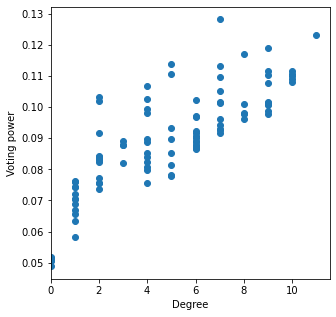

In [139]:
plt.figure(figsize=(5,5))

degrees = np.zeros(n_voters)
for i in range(n_voters):
    degrees[i]= nx.degree(G,i)
    
plt.plot(degrees, powers, 'o')
plt.xlim(0)
plt.xlabel("Degree")
plt.ylabel("Voting power")
plt.show()

In [140]:
n_voters = 100
pos_2, G_2 = network_spatial(n_voters, radius = 0.5, distrib_x = "uniform", distrib_y ="uniform")
powers_2 = network_powers(G_2, np.ones(n_voters), 0.5)

100%|██████████| 10000/10000 [01:56<00:00, 85.50it/s]


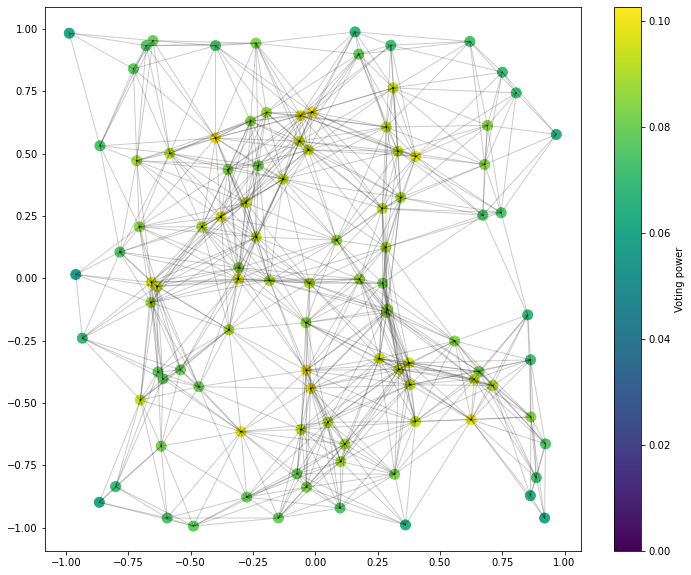

In [142]:
plt.figure(figsize=(12,10))
for i in range(n_voters):
    neighbors = list(nx.neighbors(G_2,i))
    for j in neighbors:
        if j > i:
            plt.plot([pos_2[i,0], pos_2[j,0]], [pos_2[i,1],pos_2[j,1]], 'k', linewidth=1, alpha=0.2)
sc = plt.scatter(pos_2[:,0], pos_2[:,1], c =powers_2, vmin=0, s=100)
            
plt.colorbar(sc, label="Voting power")
plt.show()

In [143]:
# Un truc ou tout le monde a le meme degree ?

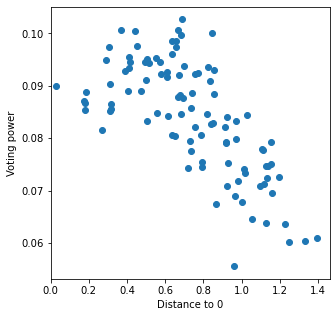

In [147]:
plt.figure(figsize=(5,5))

norm_val = np.zeros(n_voters)
for i in range(n_voters):
    norm_val[i]= (np.linalg.norm(pos_2[i]))
    
plt.plot(norm_val, powers_2, 'o')
plt.xlim(0)
plt.xlabel("Distance to 0")
plt.ylabel("Voting power")
plt.show()

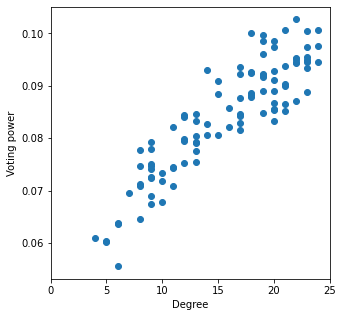

In [164]:
plt.figure(figsize=(5,5))

degrees = np.zeros(n_voters)
for i in range(n_voters):
    degrees[i]= G_2.degree(i)
    
plt.plot(degrees, powers_2, 'o')
plt.xlim(0)
plt.xlabel("Degree")
plt.ylabel("Voting power")
plt.show()

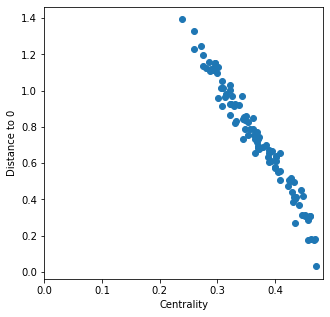

In [170]:
centrality = nx.closeness_centrality(G_2)
plt.figure(figsize=(5,5))

centrality_n = np.zeros(n_voters)
for i in range(n_voters):
    centrality_n[i]= centrality[i]
    
plt.plot(centrality_n, norm_val, 'o')
plt.xlim(0)
plt.xlabel("Centrality")
plt.ylabel("Distance to 0")
plt.show()

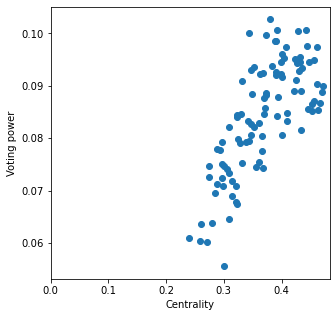

In [171]:
centrality = nx.closeness_centrality(G_2)
plt.figure(figsize=(5,5))

centrality_n = np.zeros(n_voters)
for i in range(n_voters):
    centrality_n[i]= centrality[i]
    
plt.plot(centrality_n, powers_2, 'o')
plt.xlim(0)
plt.xlabel("Centrality")
plt.ylabel("Voting power")
plt.show()

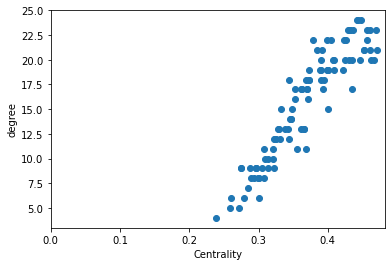

In [169]:
plt.plot(centrality_n, degrees, 'o')
plt.xlim(0)
plt.xlabel("Centrality")
plt.ylabel("degree")
plt.show()

##  G(n,p)

In [80]:
def network_random(n_voters=1000, p_edge=0.3):
    
    e_list = []
    for i in range(n_voters):
        for j in range(i+1, n_voters):
            if np.random.rand() < p_edge:
                e_list.append((i,j))
    network = nx.Graph()
    network.add_nodes_from(range(n_voters))
    network.add_edges_from(e_list)
    return network


In [82]:
n_voters = 100
G = network_random(n_voters, p_edge=0.1)
powers = network_powers(G, np.ones(n_voters))

  1%|          | 69/10000 [00:03<07:19, 22.61it/s]


KeyboardInterrupt: 

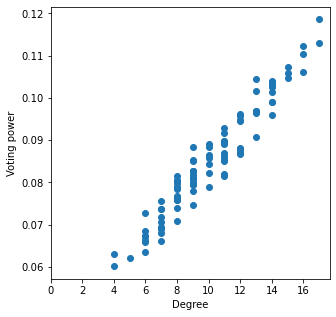

In [177]:
plt.figure(figsize=(5,5))

degrees = np.zeros(n_voters)
for i in range(n_voters):
    degrees[i]= nx.degree(G,i)
    
plt.plot(degrees, powers, 'o')
plt.xlim(0)
plt.xlabel("Degree")
plt.ylabel("Voting power")
plt.show()

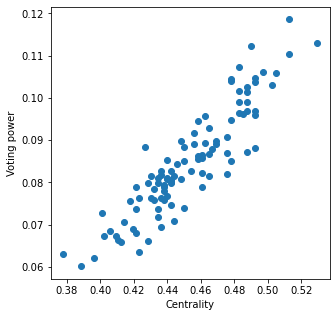

In [179]:
centrality = nx.closeness_centrality(G)
plt.figure(figsize=(5,5))

centrality_n = np.zeros(n_voters)
for i in range(n_voters):
    centrality_n[i]= centrality[i]
    
plt.plot(centrality_n, powers, 'o')
# plt.xlim(0)
plt.xlabel("Centrality")
plt.ylabel("Voting power")
plt.show()

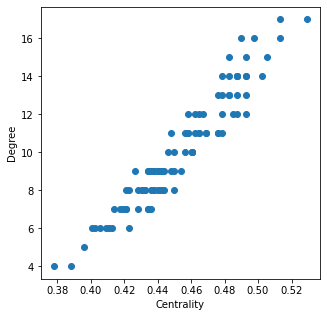

In [180]:
centrality = nx.closeness_centrality(G)
plt.figure(figsize=(5,5))

    
plt.plot(centrality_n, degrees, 'o')
# plt.xlim(0)
plt.xlabel("Centrality")
plt.ylabel("Degree")
plt.show()

## Evol avec p

In [18]:
p_tab = np.linspace(0,1,11)
n_voters = 100

powers = np.zeros((11, n_voters))
degrees = np.zeros((11, n_voters))

G_tab = []

for i, p in enumerate(p_tab):
    G = network_random(n_voters, p_edge=p)
    G_tab.append(G)
    powers[i] = network_powers(G, np.ones(n_voters))

    for j in range(n_voters):
        degrees[i, j]= nx.degree(G,j)

100%|██████████| 10000/10000 [20:52<00:00,  7.99it/s]


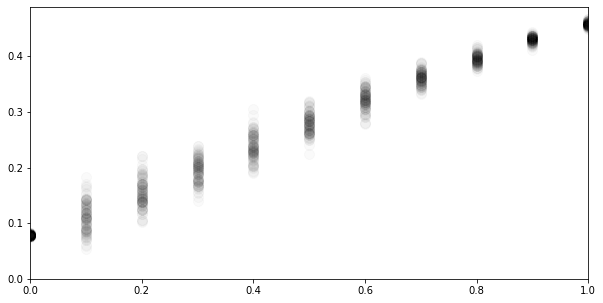

In [29]:
plt.figure(figsize=(10,5))
for i in range(11):
    plt.plot([i*0.1]*n_voters, powers[i], 'o', markersize=10, alpha=0.02, c= 'k')
plt.xlim(0,1)
plt.ylim(0)
plt.show()

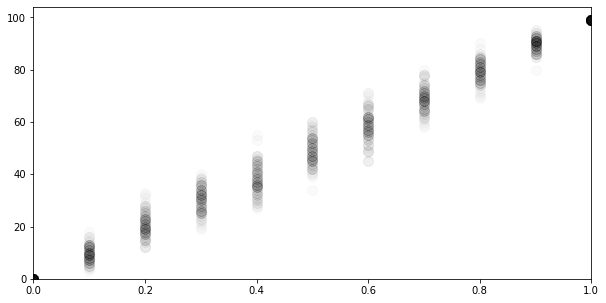

In [31]:
plt.figure(figsize=(10,5))
for i in range(11):
    plt.plot([i*0.1]*n_voters, degrees[i], 'o', markersize=10, alpha=0.02, c= 'k')
plt.xlim(0,1)
plt.ylim(0)
plt.show()

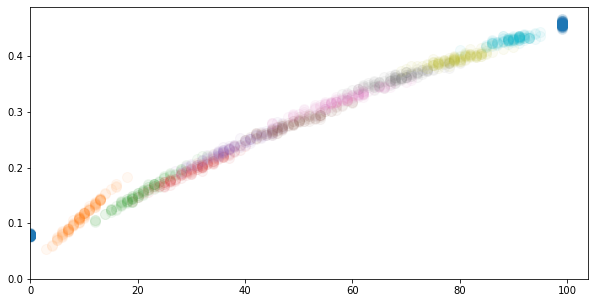

In [39]:
plt.figure(figsize=(10,5))
for i in range(11):
    plt.plot(degrees[i], powers[i], 'o', markersize=10, alpha=0.05)
plt.xlim(0)
plt.ylim(0)
plt.show()

## Bi-partite Graph

In [82]:
def network_k_partite(n_voters, p_edge=0.5):

    
    e_list = []
    s = 0
    for k in range(len(n_voters)-1):
        for i in range(n_voters[k]):
            for j in range(n_voters[k+1]):
                if np.random.rand() < p_edge:
                    e_list.append((s+i,s+n_voters[k]+j))
        s += n_voters[k]
    network = nx.DiGraph()
    network.add_nodes_from(range(np.sum(n_voters)))
    network.add_edges_from(e_list)
    return network


In [61]:
p_tab = np.linspace(0,1,11)
n_voters = 100

powers = np.zeros((11, n_voters))
degrees = np.zeros((11, n_voters))

G_tab = []

for i, p in enumerate(p_tab):
    G = network_k_partite([80,20], p_edge=p)
    G_tab.append(G)
    powers[i] = network_powers(G, np.ones(n_voters))

    for j in range(n_voters):
        degrees[i, j]= G.in_degree[j]

100%|██████████| 10000/10000 [07:35<00:00, 21.95it/s]


In [66]:
len(p)

(11, 100)

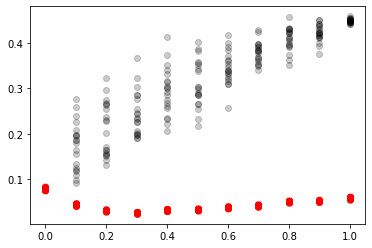

In [69]:
for i in range(20):
    plt.scatter(p_tab, powers[:,i], c='k',alpha=0.2)
for i in range(20,100):
    plt.scatter(p_tab, powers[:,i], c='r',alpha=0.2)    
plt.show()

## Multi Layer

In [89]:
p_tab = np.linspace(0,1,11)
n_voters = 50

powers = np.zeros((11, n_voters))
degrees = np.zeros((11, n_voters))

G_tab = []

for i, p in enumerate(p_tab):
    G = network_k_partite([10,10,10,10,10], p_edge=p)
    G_tab.append(G)
    powers[i] = network_powers(G, np.ones(n_voters))

    for j in range(n_voters):
        degrees[i, j]= G.in_degree[j]
        

100%|██████████| 10000/10000 [00:42<00:00, 235.21it/s]


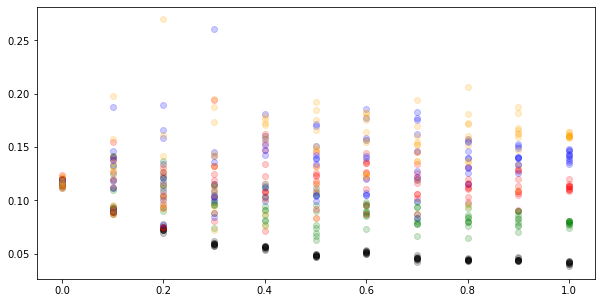

In [94]:
colors = ["black", "green", "red", "blue", "orange"]
plt.figure(figsize=(10,5))
for i in range(5):
    for j in range(i*10,(i+1)*10):
        plt.scatter(p_tab, powers[:,j], c=colors[i],alpha=0.2)
plt.show()

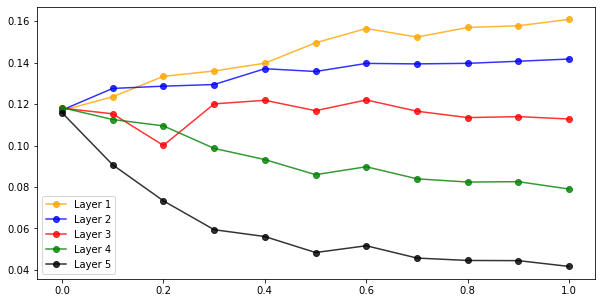

In [102]:
colors = ["black", "green", "red", "blue", "orange"]
plt.figure(figsize=(10,5))
for i in range(4,-1,-1):
    plt.plot(p_tab, powers[:,i*10:(i+1)*10].mean(1),"o-", c=colors[i],alpha=0.8, label="Layer %i"%(5-i))
plt.legend()
plt.show()

## Pyramid Scheme version

In [103]:
p_tab = np.linspace(0,1,11)
n_voters = 121

powers = np.zeros((11, n_voters))
degrees = np.zeros((11, n_voters))

G_tab = []

for i, p in enumerate(p_tab):
    G = network_k_partite([81,27,9,3,1], p_edge=p)
    G_tab.append(G)
    powers[i] = network_powers(G, np.ones(n_voters))

    for j in range(n_voters):
        degrees[i, j]= G.in_degree[j]
        

100%|██████████| 10000/10000 [03:59<00:00, 41.76it/s]


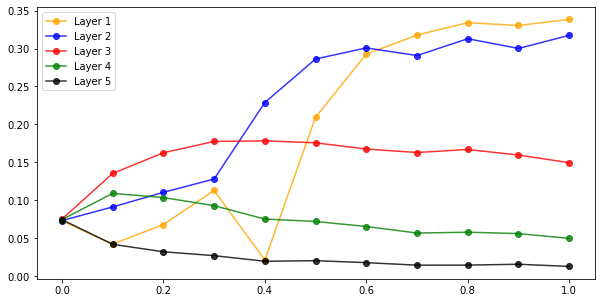

In [112]:
colors = ["black", "green", "red", "blue", "orange"]
t_p = np.cumsum([0,81,27,9,3,1])
plt.figure(figsize=(10,5))
plt.plot(p_tab, powers[:,-1],"o-", c=colors[-1],alpha=0.8, label="Layer 1")
for i in range(3,-1,-1):
    plt.plot(p_tab, powers[:,t_p[i]:t_p[i+1]-1].mean(1),"o-", c=colors[i],alpha=0.8, label="Layer %i"%(5-i))
plt.legend()
plt.show()

## Preferential attachment

In [31]:
def network_pref_attachment(n_voters, p_ok=1,w_links=0):
    G = nx.DiGraph()
    G.add_nodes_from(range(n_voters))
    n_links = 0
    for i in range(n_voters):
        for j in range(i):
            neighbors = G.in_degree[j]
            fThresh = w_links*(neighbors + 1)/ (w_links*n_links + i-j) 
            if np.random.rand() <= fThresh:
                G.add_edge(i,j)
                n_links += 1
    return G

In [37]:
p_tab = np.linspace(0,1,11)
n_voters = 100

powers = np.zeros((11, n_voters))
degrees = np.zeros((11, n_voters))

G_tab = []

for i, p in enumerate(p_tab):
    G = network_pref_attachment(n_voters, w_links=p)
    G_tab.append(G)
    powers[i] = network_powers(G, np.ones(n_voters))
    for j in range(n_voters):
        degrees[i, j]= G.in_degree[j]

100%|██████████| 10000/10000 [02:22<00:00, 70.29it/s]


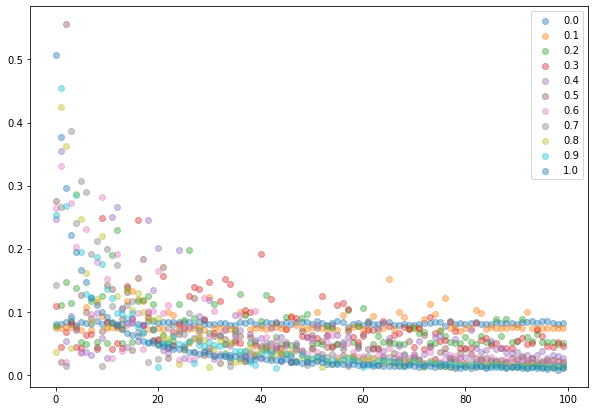

In [48]:
plt.figure(figsize=(10,7))
for i in range(11):
    plt.scatter(range(n_voters), powers[i], label="%.1f"%(i*0.1),alpha=0.4)

    
plt.legend()
plt.show()


## Small World 

We could have done (Watts-Strogatz) model but I prefer this one:

In [69]:
def network_small_world(n_voters, p_edge=1,coeff_dist=1):
    G = nx.DiGraph()
    G.add_nodes_from(range(n_voters))
    for i in range(n_voters):
        for j in range(n_voters):
            if i == j:
                continue
            if i < j:
                dist = min(j-i, i+n_voters-j)
            else:
                dist = min(i-j, j+n_voters-i)
                
            fThresh = p_edge/(dist**coeff_dist)
            if np.random.rand() <= fThresh:
                G.add_edge(i,j)
    return G

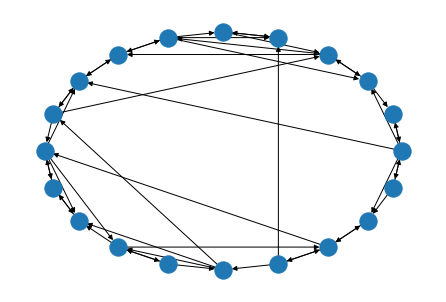

In [76]:
G = network_small_world(20,0.7,2)
nx.draw_circular(G)

In [87]:

powers = np.zeros((5, 5))
degrees = np.zeros((5, 5))
n_voters = 100

for i, p_edge in enumerate([0,0.25,0.5,0.75,1]):
    for j, coeff in enumerate([1,1.25,1.5,1.75,2]):
        G = network_small_world(n_voters, p_edge, coeff)
        powers[i,j] = network_powers(G, np.ones(n_voters)).mean()
        for k in range(n_voters):
            degrees[i, j] += G.in_degree[k]
    
degrees /= n_voters
        

100%|██████████| 10000/10000 [03:10<00:00, 52.54it/s]


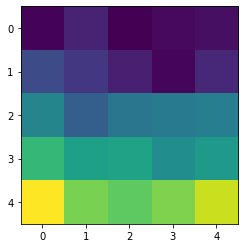

In [88]:
plt.imshow(powers)

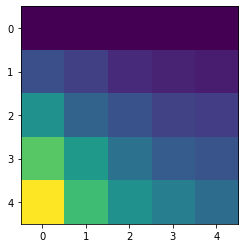

In [89]:
plt.imshow(degrees)